\# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Skillfactory---Практический-Machine-Learning" data-toc-modified-id="Skillfactory---Практический-Machine-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Skillfactory - Практический Machine Learning</a></div><div class="lev2 toc-item"><a href="#Обучение-без-учителя,-понижение-размерности,-кластеризация" data-toc-modified-id="Обучение-без-учителя,-понижение-размерности,-кластеризация-11"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Обучение без учителя, понижение размерности, кластеризация</a></div><div class="lev3 toc-item"><a href="#Иерархическая-кластеризация:-Пищевая-ценность-продуктов" data-toc-modified-id="Иерархическая-кластеризация:-Пищевая-ценность-продуктов-111"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Иерархическая кластеризация: Пищевая ценность продуктов</a></div><div class="lev2 toc-item"><a href="#DBSCAN:-Геоданные" data-toc-modified-id="DBSCAN:-Геоданные-12"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>DBSCAN: Геоданные</a></div><div class="lev3 toc-item"><a href="#Отток-в-игре:-PCA-+-RFE" data-toc-modified-id="Отток-в-игре:-PCA-+-RFE-121"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Отток в игре: PCA + RFE</a></div><div class="lev3 toc-item"><a href="#Сжатие-признаков-для-визуализации" data-toc-modified-id="Сжатие-признаков-для-визуализации-122"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Сжатие признаков для визуализации</a></div><div class="lev3 toc-item"><a href="#RFE-+-Decision-tree" data-toc-modified-id="RFE-+-Decision-tree-123"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>RFE + Decision tree</a></div>

# Skillfactory - Практический Machine Learning
## Обучение без учителя, понижение размерности, кластеризация

<center> Шестаков Андрей </center>

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [9]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, fixed, FloatSlider

### Иерархическая кластеризация: Пищевая ценность продуктов

Загрузите файл `food.txt`. В нем содержится информация о пищевой ценности разных продуктов

In [5]:
df = pd.read_csv('data/food.txt', sep=' ')
df.head()

,Name,Energy,Protein,Fat,Calcium,Iron
0,Braised beef,340,20,28,9,2.6
1,Hamburger,245,21,17,9,2.7
2,Roast beef,420,15,39,7,2.0
3,Beefsteak,375,19,32,9,2.6
4,Canned beef,180,22,10,17,3.7


In [100]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 6 columns):
Name       27 non-null object
Energy     27 non-null int64
Protein    27 non-null int64
Fat        27 non-null int64
Calcium    27 non-null int64
Iron       27 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 1.3+ KB


* Подготовте данные к кластеризации 
    * Выделите признаки в матрицу X (numpy array)
    * Отнормируйте признаки

In [20]:
import re
#from nltk.corpus import stopwords

def text_to_wordlist(text):
    text = re.sub('n\'t', ' not', text)
    
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.lower().split()
   # stops = set(stopwords.words("beef"))

    return words

In [21]:
# Do this in a separate python interpreter session, since you only have to do it once
import nltk
nltk.download('punkt')

# Do this in your ipython notebook or analysis script
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ildar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [22]:
import nltk.data
nltk.download('punkt')

def text_to_sentences(text):
    tokenizer = nltk.data.load('english.pickle')
    raw_sentences = tokenizer.tokenize(text.strip())
    
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(text_to_wordlist(raw_sentence))

    return sentences

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ildar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [23]:
%%time
sentences = []

for review in df['Name']:
    sentences += text_to_sentences(review)

Wall time: 1.99 ms


In [25]:
print (len(sentences))

27


In [37]:
for i in range(10):
    print (sentences[i])

['braised', 'beef']
['hamburger']
['roast', 'beef']
['beefsteak']
['canned', 'beef']
['broiled', 'chicken']
['canned', 'chicken']
['beef', 'heart']
['roast', 'lamb', 'leg']
['roast', 'lamb', 'shoulder']


In [60]:
from gensim.models.word2vec import Word2Vec 

# список параметров, которые можно менять по вашему желанию
num_features = 300  # итоговая размерность вектора каждого слова
min_word_count = 1  # минимальная частотность слова, чтобы оно попало в модель
num_workers = 8     # количество ядер вашего процессора, чтоб запустить обучение в несколько потоков
context = 10        # размер окна 
downsampling = 1e-3 # внутренняя метрика модели

model = Word2Vec(sentences, workers=num_workers, size=num_features,
                 min_count=min_word_count, window=context, sample=downsampling)

In [61]:

# Финализируем нашу модель. Ее нельзя будет доучить теперь, но она начнет занимать гораздо меньше места
model.init_sims(replace=True)


In [62]:
# Словарь - все слова которые участвуют в модели можно просмотреть так
model.wv.index2word

['canned',
 'beef',
 'roast',
 'broiled',
 'chicken',
 'lamb',
 'pork',
 'clams',
 'fried',
 'mackerel',
 'braised',
 'hamburger',
 'beefsteak',
 'heart',
 'leg',
 'shoulder',
 'smoked',
 'ham',
 'simmered',
 'tongue',
 'veal',
 'cutlet',
 'baked',
 'bluefish',
 'raw',
 'crabmeat',
 'haddock',
 'perch',
 'salmon',
 'sardines',
 'tuna',
 'shrimp']

In [55]:
import numpy as np

def text_to_vec(words, model, size):
    text_vec = np.zeros((size,), dtype="float32")
    n_words = 0

    index2word_set = set(model.wv.index2word)
    for word in words:
        if word in index2word_set:
            n_words = n_words + 1
            text_vec = np.add(text_vec, model[word])
    
    if n_words != 0:
        text_vec /= n_words
    return text_vec

In [56]:
def texts_to_vecs(texts, model, size):
    texts_vecs = np.zeros((len(texts), size), dtype="float32")
    
    for i, text in enumerate(texts):
        texts_vecs[i] = text_to_vec(text, model, size)

    return texts_vecs

In [66]:
X_like_word_list = [sum(text_to_sentences(text), []) for text in df['Name']]

In [75]:
X_vecs = texts_to_vecs(X_like_word_list, model, num_features)

In [76]:
import umap
umap_news=umap.UMAP()
umaped_v=umap_news.fit_transform(X_vecs)

* Произведите иерархическую кластеризацию этого набора данных (метод `linkage`)
* Выберите тип пересчета расстояния между кластерами с помощью кофенетической корреляции

In [78]:
from scipy.cluster.hierarchy import fcluster, dendrogram, linkage, cophenet

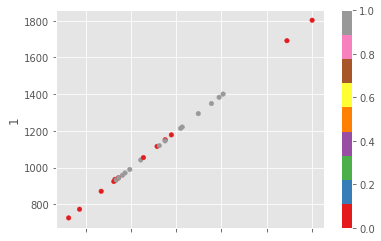

In [79]:
from sklearn.cluster import AgglomerativeClustering
ag=AgglomerativeClustering(linkage="complete", affinity="cosine")#, "average")
ag_clusters=ag.fit_predict(umaped_v)
ax=pd.DataFrame(umaped_v).plot.scatter(x=0, y=1, c=ag_clusters, cmap=plt.cm.Set1)

* Изобразите дендрограмму
    * Сначала просто посмотрите на результат метода `dendrogram`
    * Сделаем визуализацию более наглядной:
        * Выделите названия продуктов в numpy array c названием `names`
        * Выполните `dendrogram`  аргументами `orientation='left'`, `labels=names`
        * Теперь мы должны увидеть, что дендрограмма транспонировалась и вместо безымянных индексов мы имеем наименования объектов

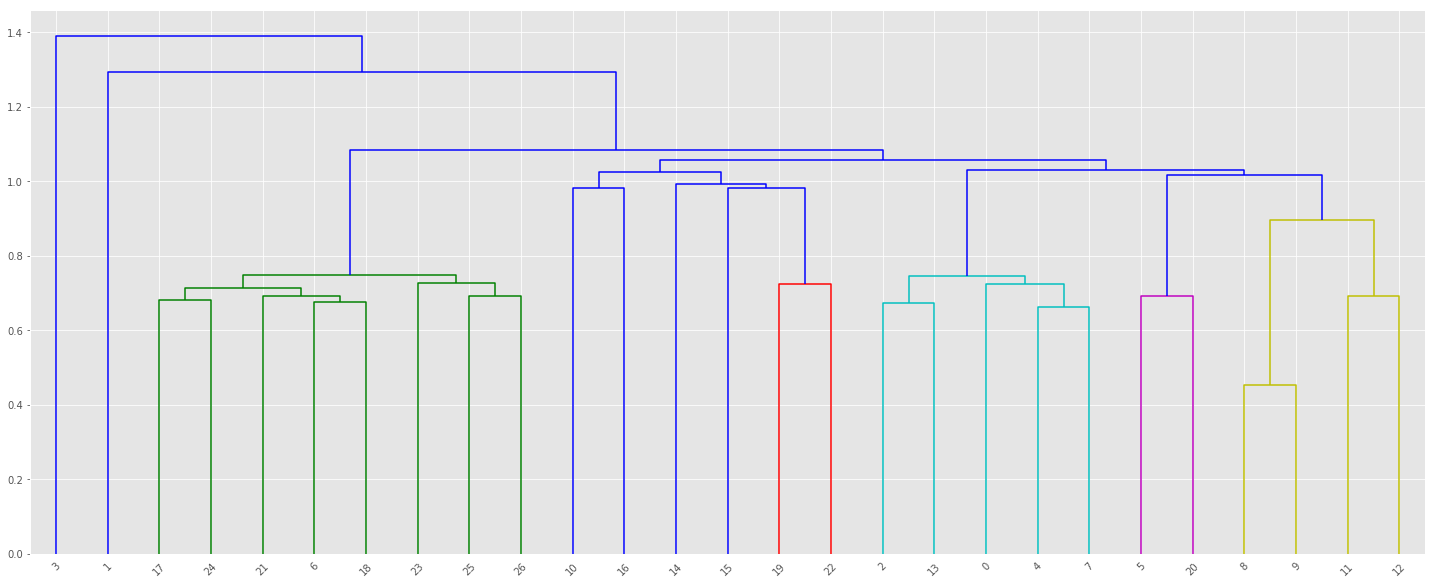

In [80]:
# дендрограмма
Z = linkage(X_vecs, method='complete', metric='euclidean')
fig = plt.figure(figsize=(25, 10))
_ = dendrogram(Z)

In [105]:
# Выделим названия продуктов в numpy array c названием names
names = np.array(df['Name'], object)


In [106]:
names

array(['Braised beef', 'Hamburger', 'Roast beef', 'Beefsteak',
       'Canned beef', 'Broiled chicken', 'Canned chicken', 'Beef heart',
       'Roast lamb leg', 'Roast lamb shoulder', 'Smoked ham',
       'Pork roast', 'Pork simmered', 'Beef tongue', 'Veal cutlet',
       'Baked bluefish', 'Raw clams', 'Canned clams', 'Canned crabmeat',
       'Fried haddock', 'Broiled mackerel', 'Canned mackerel',
       'Fried perch', 'Canned salmon', 'Canned sardines', 'Canned tuna',
       'Canned shrimp'], dtype=object)

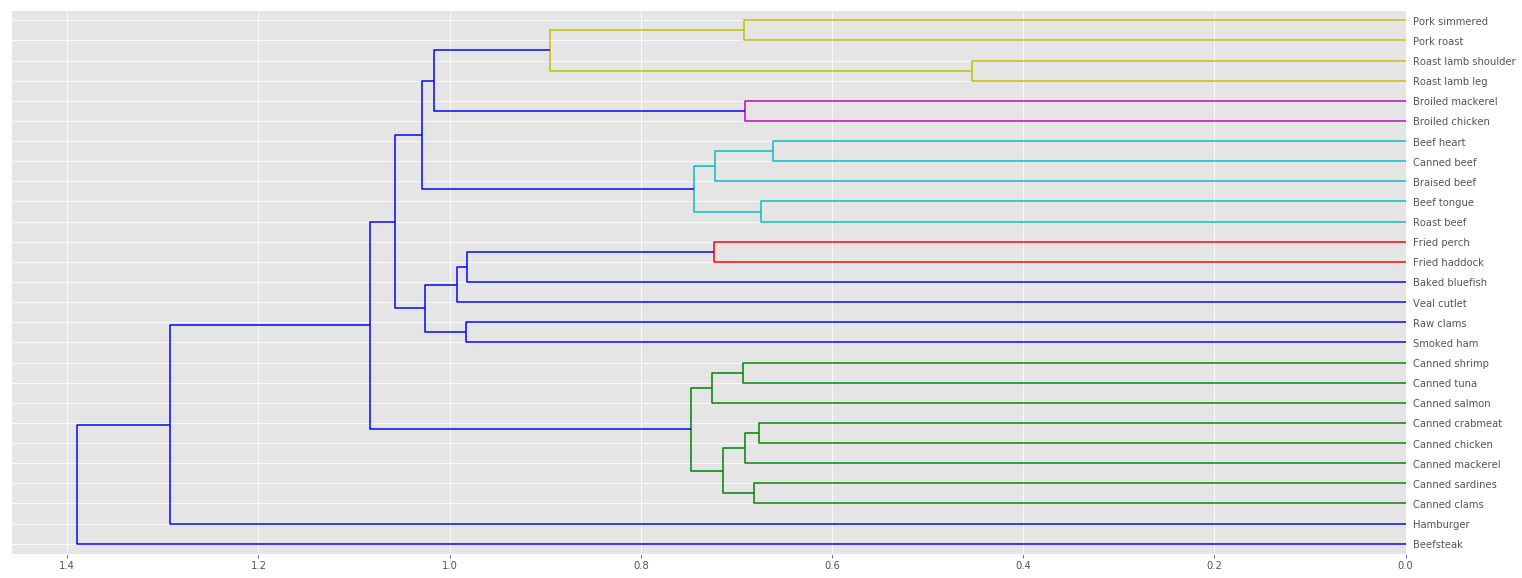

In [130]:
Z = linkage(X_vecs, method='complete', metric='euclidean')
fig = plt.figure(figsize=(25, 10))
dendr = dendrogram(Z, labels=names, orientation='left')
#H = dendrogram(tree,'Orientation','left','ColorThreshold','default');


* Выделите кластеры по дендрограмме с помощью метода `fcluster`
    * Наличие кластеров, состоящих из одного объекта - нормальное явление, если это можно объяснить

In [138]:
import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, IntSlider, fixed, FloatSlider
from sklearn.datasets import make_blobs

In [139]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import fcluster

In [140]:

def coph_demo(link='single', metric='euclidean', k=2):
    
    X, y = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1,
                  center_box=(-10.0, 10.0),
                  shuffle=True,
                  random_state=1) 
    
    d = pdist(X, metric=metric)

    Z = linkage(X, method=link, metric=metric)
    labels = fcluster(Z,  k, criterion='maxclust')
    
    fig, ax = plt.subplots(1,2)
    
    ax[0].scatter(X[:,0], X[:,1], c=labels)
        
    ax[0].set_xlabel('$x_1$')
    ax[0].set_ylabel('$x_2$')
        
    dend = dendrogram(Z, ax=ax[1], truncate_mode='lastp')   
    coph_corr, coph_dist = cophenet(Z, d)
    
    ax[1].set_title('cophCorr = %.3f' % coph_corr)
    
    plt.show()

In [141]:
interact(coph_demo, k=IntSlider(min=2, max=10, step=1, value=2), link=['complete', 'single', 'average', 'centroid'], metric=['euclidean', 'cityblock'])

interactive(children=(Dropdown(description='link', index=1, options=('complete', 'single', 'average', 'centroi…

<function __main__.coph_demo(link='single', metric='euclidean', k=2)>

In [ ]:
# УРА!

## DBSCAN: Геоданные

In [8]:
# Опционально, установите установите matplotlib.basemap
# Либо закоментируйте команду ниже

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import os
# Не импортировался Basemap, нашел решение на форумах
from mpl_toolkits.basemap import Basemap
#import mpl_toolkits.basemap as bm
#os.environ['PROJ_LIB'] = r'C:\Users\Ildar\Anaconda3\pkgs\proj4-5.1.0-hfa6e2cd_1\Library\share'
import mpl_toolkits.basemap as bm

Загрузите геоданные из `geo_data.txt` (lat, lon).

Будем пытаться кластеризовать данные с помощью DBSCAN и меры [haversine](https://en.wikipedia.org/wiki/Haversine_formula)

In [9]:
df_geo = pd.read_csv('data/geo_data.txt', sep='\t', header=None,
                     names=['lat', 'lon'])/10000

In [10]:
df_geo.head()

,lat,lon
0,62.5983,29.7439
1,62.6146,29.7440
2,62.6144,29.7456
3,62.6004,29.7394
4,62.6018,29.7437


In [14]:
def plot_geo(lat, lon, labels=None):    
    try:
        lllat, lllon = lat.min()-1, lon.max()+1
        urlat, urlon = lat.max()+1, lon.min()-1

        plt.figure(figsize=(10, 10))

        m = bm.Basemap(
            llcrnrlon=lllon,
            llcrnrlat=lllat,
            urcrnrlon=urlon,
            urcrnrlat=urlat, 
            projection='merc',
            resolution='h'
        )

        m.drawcoastlines(linewidth=0.5)
        m.drawmapboundary(fill_color='#47A4C9', zorder=1)
        m.fillcontinents(color='#EBC4D8',lake_color='#47A4C9', zorder=2)

        parallels = np.linspace(lllat, urlat, 10)
        m.drawparallels(parallels,labels=[1,0,0,0],fontsize=10)
        # draw meridians
        meridians = np.linspace(urlon, lllon, 10)
        m.drawmeridians(meridians,labels=[0,0,0,1],fontsize=10)

        m.scatter(lon, lat, latlon=True, cmap=plt.cm.jet,
              zorder=3, lw=0, c=labels)
    except:
        print('что-то пошло не так')
        plt.scatter(x=lon, y=lat, c=labels, cmap=plt.cm.jet)
        plt.axis('equal')

Для начала нарисуем все точки на карте

что-то пошло не так


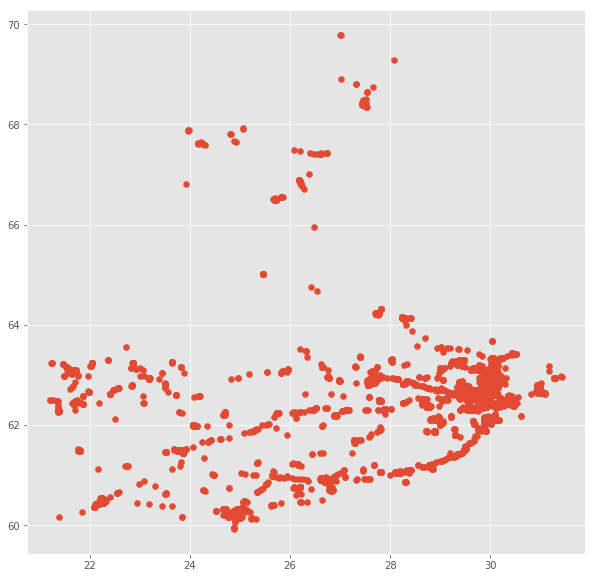

In [15]:
plot_geo(df_geo.loc[:, 'lat'].values, df_geo.loc[:, 'lon'].values)

Это данные с check-in людей в foursquare. В данных могут быть ошибки и просто непопулярные заведения.

Мы будем использовать расстояние haversine - на входе требуются координаты в **радианах**. Выход тоже будет в радианах. Чтобы перейти от градусов в радианты мы можем вспомнить тригонометрию, а можем воспользоваться функцией `np.radians`.

Для кого, чтобы не терять связь с реальностью, будем иметь ввиду, что расстояние в 1 радиан на земном шаре равно примерно 6371.0088 километрам.

Создайте матрицу X с координатами в радианах

In [17]:
km_in_radian = 6371.0088
X = np.radians(df_geo.values)

In [63]:
X

array([[1.09254644, 0.51912899],
       [1.09283093, 0.51913073],
       [1.09282744, 0.51915866],
       ...,
       [1.09266338, 0.5190679 ],
       [1.09256739, 0.5191063 ],
       [1.0925447 , 0.51911502]])

Как же определить, какие параметры для DBSCAN выставлять? Наибольшую проблемы представляет параметр eps.

Будем считать, что MinPts нам дан свыше  например для себя мы определили, что кластером будет считаться группа из **минимум** 20 точек - MinPts = 20). Воспользуемся следующим способом оценки:

* Расчитайте расстояние до k=MinPts ближайшего соседа каждой точки (класс `NearestNeighbors` и метод `kneighbors`)
* Отсортируйте полученный массив и выведите его на график
* По графику будет примерно понятно, сколько точек уйдет в шум, а сколько попадет в полноценный кластер при всевозможных `eps`
* Выберите eps, при котором график начинает "уходить вверх" (примерно 0.02-0.06, если все было сделано верно)

In [91]:
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
nn = NearestNeighbors(n_neighbors=20)
nn.fit(X)
A=nn.kneighbors(X, return_distance=True)

In [94]:
A # В этом массиве сначала идут расстояние потом число K-neighbors of a point, оставим только distance
A_dist=A[0]

In [95]:
A_dist

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.74532925e-06, 1.74532925e-06, 1.74532925e-06],
       [0.00000000e+00, 2.46826830e-06, 3.49065850e-06, ...,
        8.72664626e-06, 8.72664626e-06, 8.72664626e-06],
       [0.00000000e+00, 3.90267485e-06, 7.19617686e-06, ...,
        1.92777917e-05, 1.95133743e-05, 1.95133743e-05],
       ...,
       [0.00000000e+00, 2.46826830e-06, 2.46826830e-06, ...,
        9.39888566e-06, 9.39888566e-06, 9.87307320e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.29287411e-06, 7.19617686e-06, 7.19617686e-06],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.46826830e-06, 2.46826830e-06, 2.46826830e-06]])

In [96]:
import umap
umap_=umap.UMAP()
umaped_v1=umap_.fit_transform(A_dist)

C:\Users\Ildar\Anaconda3\lib\site-packages\umap\spectral.py:229: UserWarning: Embedding a total of 47 separate connected components using meta-embedding (experimental)
  n_components


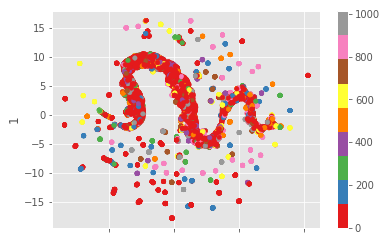

In [108]:
# Пробуем DBSCAN
from sklearn.cluster import DBSCAN
db=DBSCAN(eps=0.03, min_samples=3)
db_clusters=db.fit_predict(umaped_v1)
ax=pd.DataFrame(umaped_v1).plot.scatter(x=0, y=1, c=db_clusters, cmap=plt.cm.Set1)

In [ ]:
#### График начинает "  уходить вверх" при EPS = 0.03 ####

Определим eps мы можем начать кластеризацию

* Создайте экземпляр класса DBSCAN, кластеризуйте данные
* Выведите полученные метки кластеров и их частоты
* Интерпретировать кластеры может оказаться затруднительно, но можно избавить от выборов и посмотреть на результат
    * Изобразите координаты точек, не попавших в кластер выбросов (метка -1) 

In [182]:
clustering = DBSCAN(eps=0.2, min_samples=3).fit(df_geo)

In [163]:
clustering.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

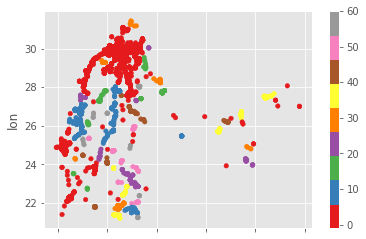

In [183]:
db_clusters=clustering.fit_predict(df_geo)
ax=pd.DataFrame(df_geo).plot.scatter(x=0, y=1, c=db_clusters, cmap=plt.cm.Set1)

In [200]:
labels = clustering.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [201]:
n_clusters_

61

In [205]:
clusters = [db_clusters[labels==i] for i in range(n_clusters_)]

In [206]:
#Метки Кластеров
clusters

[array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int64),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2,

In [207]:
#Выбросы
outliers = X[labels == -1]
outliers

array([[1.09301943, 0.46821424],
       [1.1509312 , 0.46196945],
       [1.18541017, 0.43741616],
       [1.18554806, 0.43725559],
       [1.05368843, 0.4125138 ],
       [1.05368494, 0.40899871],
       [1.05447383, 0.404501  ],
       [1.0547653 , 0.40030697],
       [1.06167157, 0.40119884],
       [1.06261055, 0.4028953 ],
       [1.10946741, 0.49815711],
       [1.16615047, 0.41748974],
       [1.06085475, 0.40682752],
       [1.13024555, 0.46104618],
       [1.12884929, 0.46313708],
       [1.11248508, 0.50074718],
       [1.16954164, 0.46040913],
       [1.06003445, 0.4325083 ],
       [1.06002398, 0.43251877],
       [1.05575839, 0.46475849],
       [1.17742529, 0.45713315],
       [1.17799602, 0.4552447 ],
       [1.20264181, 0.47159145],
       [1.20106927, 0.47690075],
       [1.2010588 , 0.47686933],
       [1.08218093, 0.43236518],
       [1.04993946, 0.41608475],
       [1.04994121, 0.41608475],
       [1.21793788, 0.4714047 ],
       [1.21795184, 0.47120225],
       [1.

### Отток в игре: PCA + RFE

В этих данных предлагается построить модель оттока игрока из игрового проекта

Целевой мерой является `log_loss` - чем меньше значение, тем лучше. Для того, чтобы считать `log_loss`, например в `cross_val_score`, необходимо выставить `scoring=neg_log_loss`. Тогда на выходе вы получите **отрицательный** log_loss, который, соответственно, надо максимизировать

In [10]:
import seaborn as sns

In [11]:
df_X = pd.read_csv('data/x_train.csv', sep=';')
df_y = pd.read_csv('data/y_train.csv', names=['target'])

In [12]:
df = df_X.join(df_y)

In [146]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25289 entries, 0 to 25288
Data columns (total 13 columns):
maxPlayerLevel                        25289 non-null int64
numberOfAttemptedLevels               25289 non-null int64
attemptsOnTheHighestLevel             25289 non-null int64
totalNumOfAttempts                    25289 non-null int64
averageNumOfTurnsPerCompletedLevel    25289 non-null float64
doReturnOnLowerLevels                 25289 non-null int64
numberOfBoostersUsed                  25289 non-null int64
fractionOfUsefullBoosters             25289 non-null float64
totalScore                            25289 non-null int64
totalBonusScore                       25289 non-null int64
totalStarsCount                       25289 non-null int64
numberOfDaysActuallyPlayed            25289 non-null int64
target                                25289 non-null int64
dtypes: float64(2), int64(11)
memory usage: 2.5 MB


Для начала визуализируйте графики со всеми парами исходных признаков с помощью `sns.pairplot` с раскраской по целевой переменной `target`.

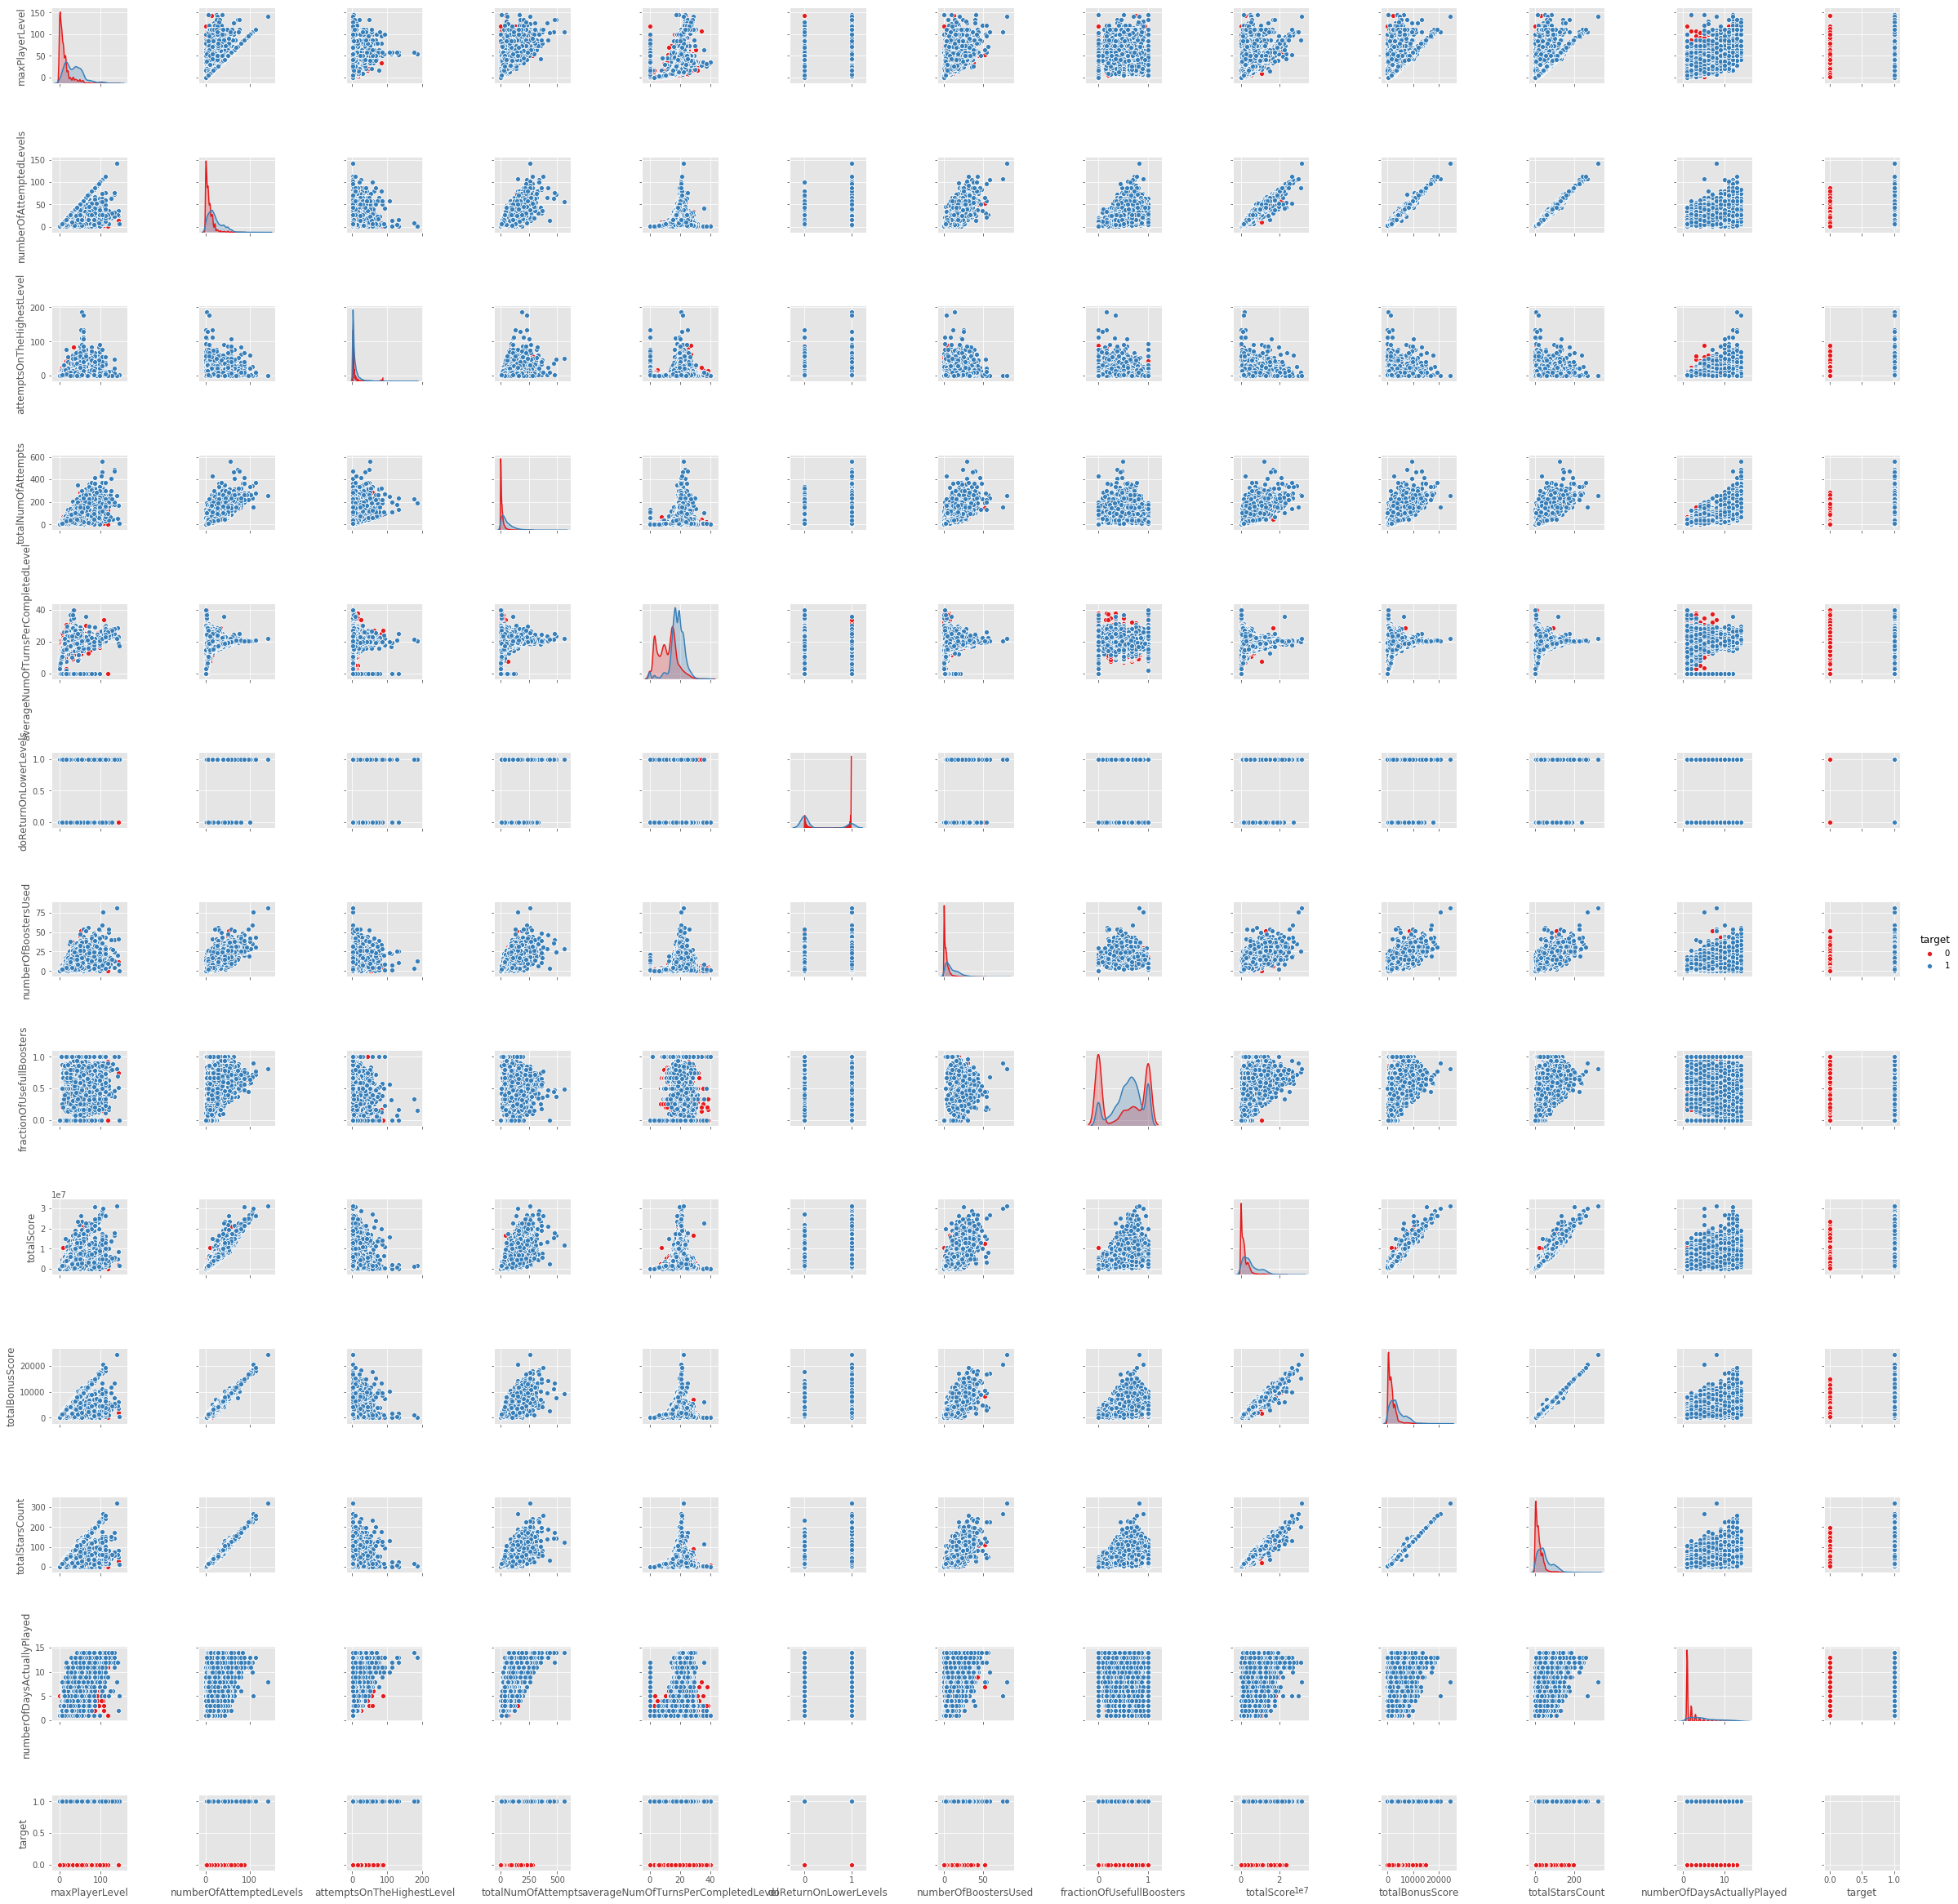

In [93]:
sns.pairplot(df, hue='target', palette="Set1")

### Сжатие признаков для визуализации

In [23]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

Составьте pipeline, в котором
* Признаки будут нормироваться
* Будет выполняться `PCA` преобразование на 3 компоненты

In [61]:
pipeline = Pipeline([('scaling', StandardScaler()),
                     ('pca', PCA(n_components=3, whiten=True))])
df_x= df.drop(['target'], axis=1)

Обучите pipeline на данных (без целевой переменной)

In [92]:
fit_pipeline = pipeline.fit(df_X)

Какую **суммарную долю** исходной дисперсии содержат в себе полученные компоненты?

In [74]:
pca = PCA(n_components=3)
fit_PCA=pca.fit(df_X)
print('Компоненты: ',fit_PCA.components_)
print('Суммарная доля исходной дисперсии: ',fit_PCA.explained_variance_ratio_)
print('Дисперсии осей проекции : ',fit_PCA.explained_variance_)

Компоненты:  [[ 3.36809723e-06  3.72768791e-06  5.49446237e-07  9.34494234e-06
   9.73973855e-07  3.26489108e-08  1.65843184e-06  3.86490938e-08
   9.99999804e-01  6.25898345e-04  8.49228662e-06  5.00256552e-07]
 [ 3.25791565e-03 -4.79132715e-03  8.82589633e-04 -5.88189563e-03
   2.93255146e-04  1.91580439e-04 -1.06402214e-03 -2.19779333e-04
   6.25995740e-04 -9.99895692e-01 -1.17455461e-02  7.56736440e-05]
 [ 4.83356382e-01  4.10898059e-02  1.35687533e-01  8.55058102e-01
   7.50686471e-02  3.54007924e-03  6.68184031e-02 -2.96143918e-03
  -7.85899294e-06 -3.93046677e-03  3.02576253e-02  6.39569862e-02]]
Суммарная доля исходной дисперсии:  [9.99999988e-01 1.19339810e-08 6.33926030e-11]
Дисперсии осей проекции :  [1.16647874e+13 1.39207352e+05 7.39461244e+02]


Изобразите сжатые данные в пространстве перых двух компонент. Раскрасте точки в цвет "класса".

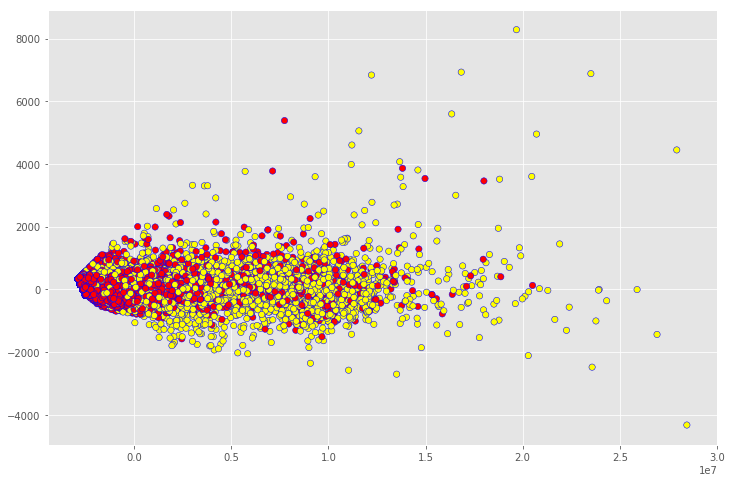

In [88]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
def plot_PCA(pca_coord):

    pca=PCA(n_components=3)
    show_reduced = pca.fit_transform(pca_coord)

    fig, ax = plt.subplots()
    ax.scatter(show_reduced[:, 0], show_reduced[:, 1], 
               cmap=plt.cm.autumn, c=df.target, edgecolor='b', s=40)
    plt.show()
    
plot_PCA(df)

### RFE + Decision tree

In [96]:
from sklearn.feature_selection import RFECV
from sklearn.tree import DecisionTreeClassifier

In [97]:
try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

try:
    from sklearn.model_selection import StratifiedKFold
except ImportError:
    from sklearn.cross_validation import StratifiedKFold

In [111]:
y = df_y['target']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = \
train_test_split(df_X, y, test_size=0.33, random_state=1)

Составьте модель, которая будет состоять из дерева решений, обернутое в RFECV
* Задайте схему кроссвалидации StratifiedKFold с 5 фолдами, перемешиванием и фиксированным random_state
* Для RFECV укажите scoring='neg_log_loss' и в параметр cv передайте схему из пункта выше

In [174]:
model = DecisionTreeClassifier(random_state=123, max_depth=9, max_features=1)

cv1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)

#train_scores, valid_scores = validation_curve(model, df_X, df_y, 
#                                              'max_depth', range(1, 10),
#                                              cv=cv, scoring='roc_auc')

selector = RFECV(model, step=1, cv=cv1, scoring='neg_log_loss')
selector = selector.fit(X_train, y_train)

predict=selector.predict(X_test)

In [176]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, predict)

0.7384957632985352

* Обучите модель с разной максимальной глубиной дерева (от 3 до 7). 
* Для каждого значения глубины постройте график изменения качества модели в зависимости от количества признаков
* Для наилучшей настройки выведите название отобранных признаков

In [227]:
# Изменение качества модели в зависимости от количества признаков и глубины дерева 
# Было выполнено на одном графике для лучшей наглядности

def plot_tree(depth=3, features=0.1,):
        
   # plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y_train)
   # plt.xlabel('$x_1$')
   # plt.ylabel('$x_2$')
        
    model = DecisionTreeClassifier(random_state=123, max_depth=depth, max_features=features)
    cv1 = StratifiedKFold(n_splits=5, shuffle=True, random_state=57)
    selector = RFECV(model, step=1, cv=cv1, scoring='neg_log_loss')
    selector = selector.fit(X_train, y_train)
    y_pred_proba=selector.predict_proba(X_test)[::,1]
    
    y_pred=selector.predict(X_test)
    print("Accuracy", metrics.accuracy_score(y_test, y_pred))
    
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label="df,"+" depth="+str(depth)+", features="+str(features))
    plt.legend(loc=4)
    plt.show()

In [228]:
fig = interact(plot_tree, depth=IntSlider(min=3, max=7, value=1), features=FloatSlider(min=0.1, max=1, value=0.1))

interactive(children=(IntSlider(value=3, description='depth', max=7, min=3), FloatSlider(value=0.1, descriptio…